Drainage modelling - May 2023 flood event
===

This notebook presents an end-to-end drainage modelling workflow using the characterised isobasin approach described in Chapter 6 of the thesis Digital Twins for Highways: A cross-asset framework 

Imports and requirements 
--

In [ ]:
import geopandas as gpd
from sqlalchemy import create_engine
import psycopg2
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import networkx as nx
import datetime
import time

# optimisation libraries.
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from scipy.optimize import differential_evolution, curve_fit
from sklearn.preprocessing import MinMaxScaler
import spotpy
import optuna
import multiprocessing
from joblib import Parallel, delayed

# plotting and quality of life libraries.
from typing import Callable, Sequence, Tuple, Dict
from scipy.stats import skew, kurtosis
import seaborn as sns 
import pyswarms as ps


# Create a connection string
db_connection_string = "postgresql://<username>:<password>@service:5432/<database>" # cleaned to remove personally identifying usernames etc.
engine = create_engine(db_connection_string)


Plotting and Preprocessing
---

The functions below are convenience plotting functions to generate consistent hydrographs, as well as documenting the baseflow removal preprcessing function.

In [ ]:

def plot_hydrograph(df_local):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot rain data as bars on left axis
    color1 = 'tab:blue'
    ax1.set_xlabel('DateTime', fontsize=12)
    ax1.set_ylabel('Rainfall (mm)', color=color1, fontsize=12)
    bars = ax1.bar(df_local['dateTime'], df_local['value_rain'], 
               color=color1, alpha=0.7, width=0.02, label='Rainfall')  # width may need adjustment
    ax1.tick_params(axis='y', labelcolor=color1)

    # Create secondary axis for flow data
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Flow Rate m^3', color=color2, fontsize=12)
    line2 = ax2.plot(df_local['dateTime'], df_local['value_flow'], 
                 color=color2, linewidth=2, label='Flow, m^3')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Format x-axis for better date display
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Add title and grid
    plt.title('Rainfall vs Flow Rate Time Series', fontsize=14, fontweight='bold')
    fig.tight_layout()
    ax1.grid(True, alpha=0.3)

    plt.show()

def plot_flow_depth(df_local):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot flow data on left axis
    color1 = 'tab:blue'
    ax1.set_xlabel('DateTime', fontsize=12)
    ax1.set_ylabel('Flow Rate (m³/s)', color=color1, fontsize=12)
    line1 = ax1.plot(df_local['dateTime'], df_local['value_flow'], 
                     color=color1, linewidth=2, label='Flow')
    ax1.tick_params(axis='y', labelcolor=color1)

    # Create secondary axis for depth data
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Depth (m)', color=color2, fontsize=12)
    line2 = ax2.plot(df_local['dateTime'], df_local['value_depth'], 
                     color=color2, linewidth=2, label='Depth')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Format x-axis for better date display
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Add title and grid
    plt.title('Flow Rate vs Depth Time Series', fontsize=14, fontweight='bold')
    fig.tight_layout()
    ax1.grid(True, alpha=0.3)

    plt.show()


def plot_flow_depth_adjusted(df_local, flow_column = 'flow_with_base_flow_removed', depth_column = 'depth_with_base_depth_removed'):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot flow data on left axis
    color1 = 'tab:blue'
    ax1.set_xlabel('DateTime', fontsize=12)
    ax1.set_ylabel('Flow Rate (m³/s)', color=color1, fontsize=12)
    line1 = ax1.plot(df_local['dateTime'], df_local[flow_column], 
                     color=color1, linewidth=2, label='Flow')
    ax1.tick_params(axis='y', labelcolor=color1)

    # Create secondary axis for depth data
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Depth (m)', color=color2, fontsize=12)
    line2 = ax2.plot(df_local['dateTime'], df_local[depth_column], 
                     color=color2, linewidth=2, label='Depth')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Format x-axis for better date display
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Add title and grid
    plt.title('Flow Rate vs Depth Time Series', fontsize=14, fontweight='bold')
    fig.tight_layout()
    ax1.grid(True, alpha=0.3)

    plt.show()


def remove_baseflow(depth_series, alpha):
#    Applies a simple Lyne-Hollick recursive filter to remove baseflow.
    depth_series = np.array(depth_series, dtype=float)
    n = len(depth_series)
    baseflow = np.zeros(n)
    quickflow = np.zeros(n)
    
    # first value
    baseflow[0] = depth_series[0]
    
    # recursive filtering
    for t in range(1, n):
        baseflow[t] = alpha * baseflow[t-1] + (1 + alpha)/2 * (depth_series[t] - depth_series[t-1])
        # ensure baseflow <= observed
        if baseflow[t] > depth_series[t]:
            baseflow[t] = depth_series[t]
    
    quickflow = depth_series - baseflow
    quickflow[quickflow < 0] = 0.0  # remove negative values
    
    return quickflow, baseflow



Data selection and event trimming
--

Select the May 2023 storm event, and plot the hydrographs.

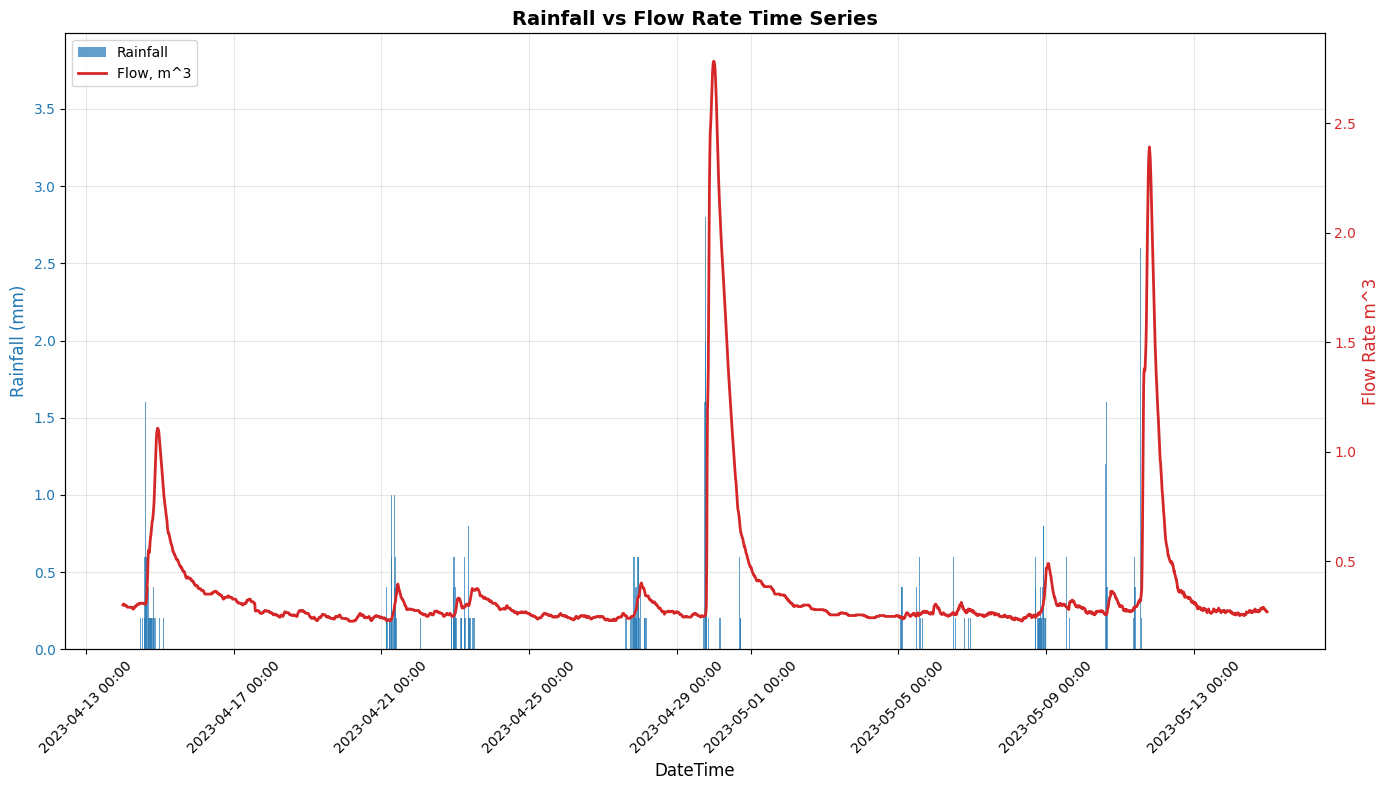

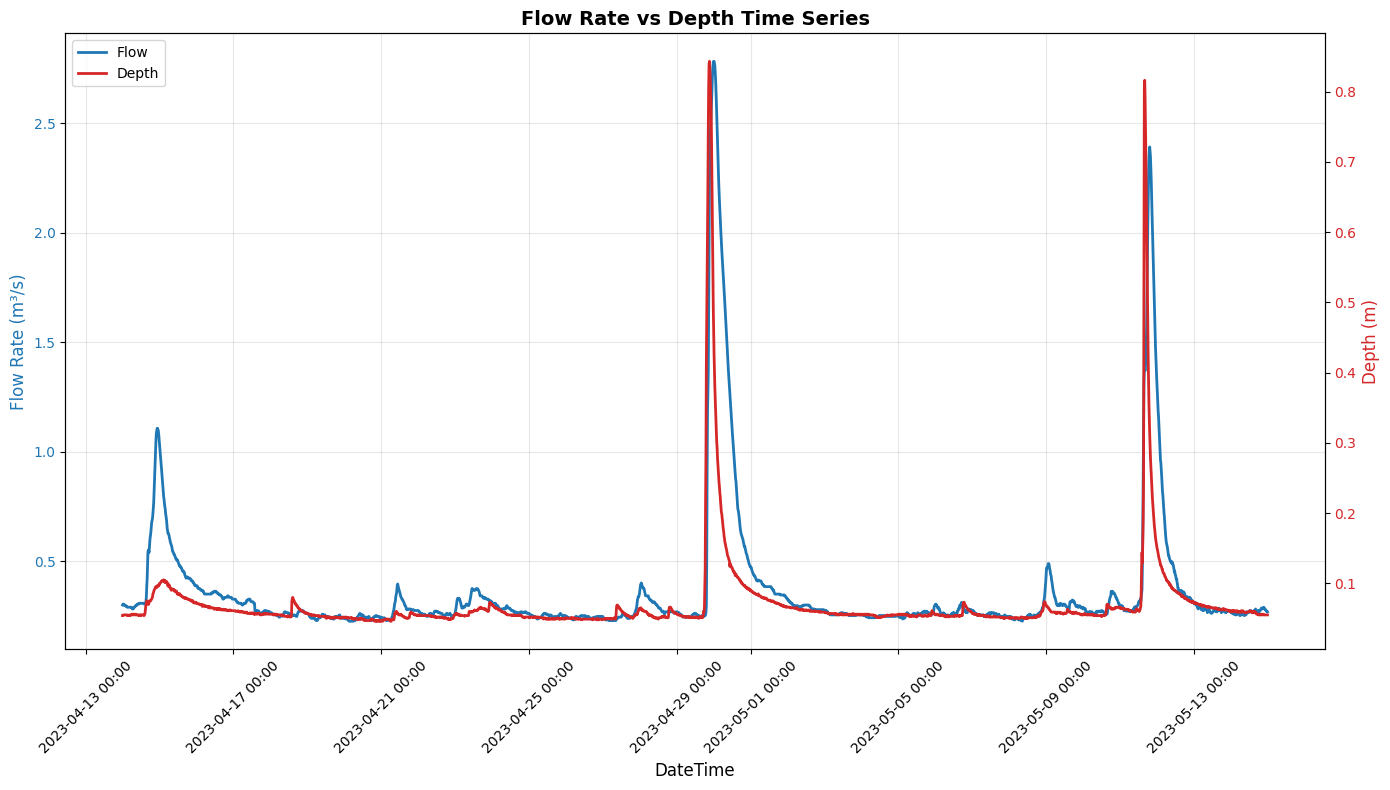

,dateTime,value_rain,value_flow,value_depth
count,2976,2976.000000,2976.000000,2976.000000
mean,2023-04-29 11:52:29.999999744,0.027419,0.362834,0.070705
min,2023-04-14 00:00:00,0.000000,0.225000,0.046000
25%,2023-04-21 17:56:15,0.000000,0.251000,0.053000
50%,2023-04-29 11:52:30,0.000000,0.271000,0.056000
75%,2023-05-07 05:48:45,0.000000,0.322000,0.064000
max,2023-05-14 23:45:00,3.800000,2.782000,0.843000
std,NaN,0.153396,0.326850,0.069618


In [ ]:

# load the data. Configured as a template. 
identifier = 'May_2023'
folder = 'datasets/'+identifier+'/'

rainfall = folder + 'Calverton-rainfall-15min-Qualified.csv'
flow = folder + 'Lowdham-flow-15min-Qualified.csv'
depth = folder + 'Oxton-Dumble-level-15min-Qualified.csv'

df_rain = pd.read_csv(rainfall)
df_flow = pd.read_csv(flow)
df_depth = pd.read_csv(depth)

df_rain_subset = df_rain[['dateTime', 'value']]
df_flow_subset = df_flow[['dateTime', 'value']]
df_depth_subset = df_depth[['dateTime', 'value']]

# Rename the columns before merging
df_rain_renamed = df_rain_subset.rename(columns={'value': 'value_rain'})
df_flow_renamed = df_flow_subset.rename(columns={'value': 'value_flow'})
df_depth_renamed = df_depth_subset.rename(columns={'value': 'value_depth'})

# Then merge
df_combined = df_rain_renamed.merge(
    df_flow_renamed, 
    on='dateTime', 
    how='outer'
).merge(
    df_depth_renamed,
    on='dateTime',
    how='outer'
)

# convert to actual date times instead of strings
df_combined['dateTime'] = pd.to_datetime(df_combined['dateTime'])

plot_hydrograph (df_combined)
plot_flow_depth(df_combined)
df_combined.describe()

Event Clipping
--
Trim the hydrograph to encompass a single rainfall event. 


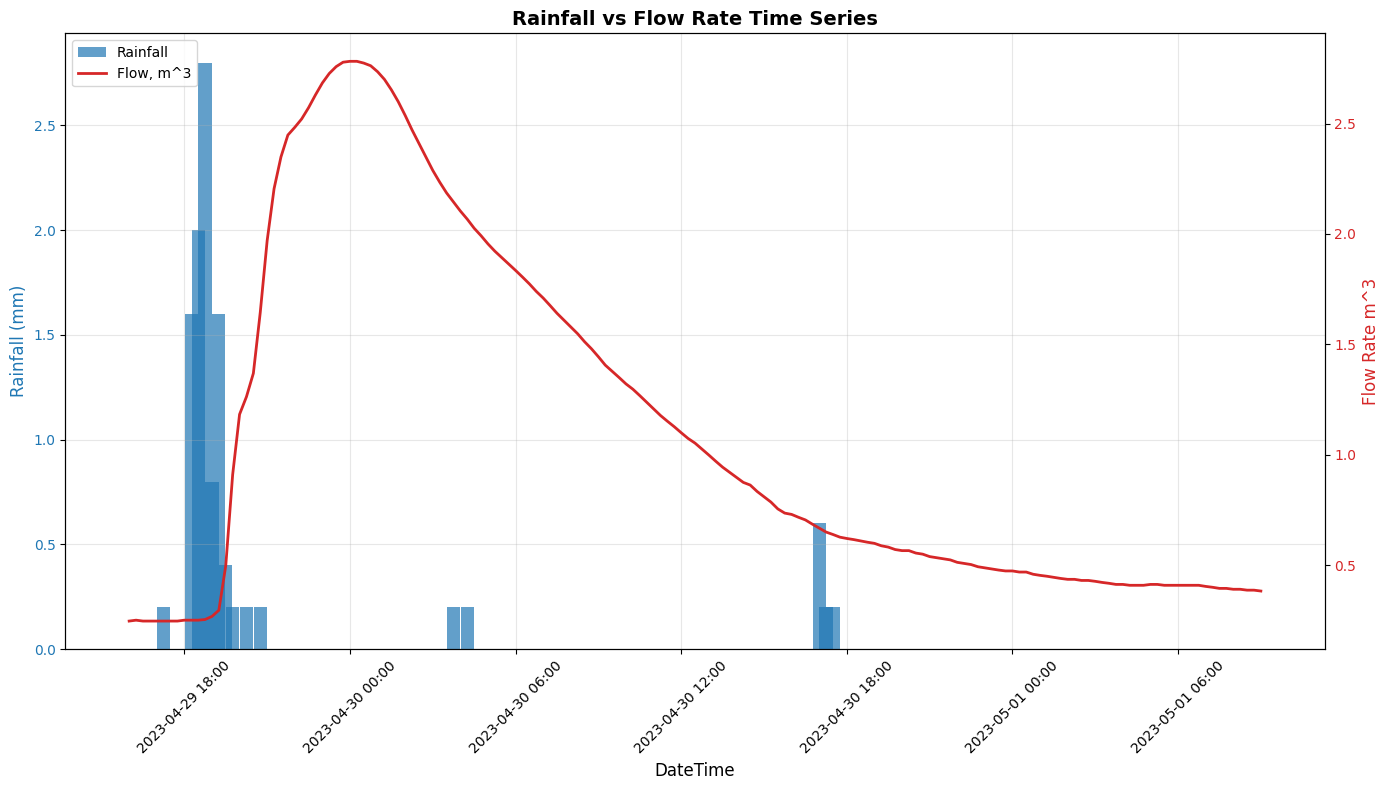

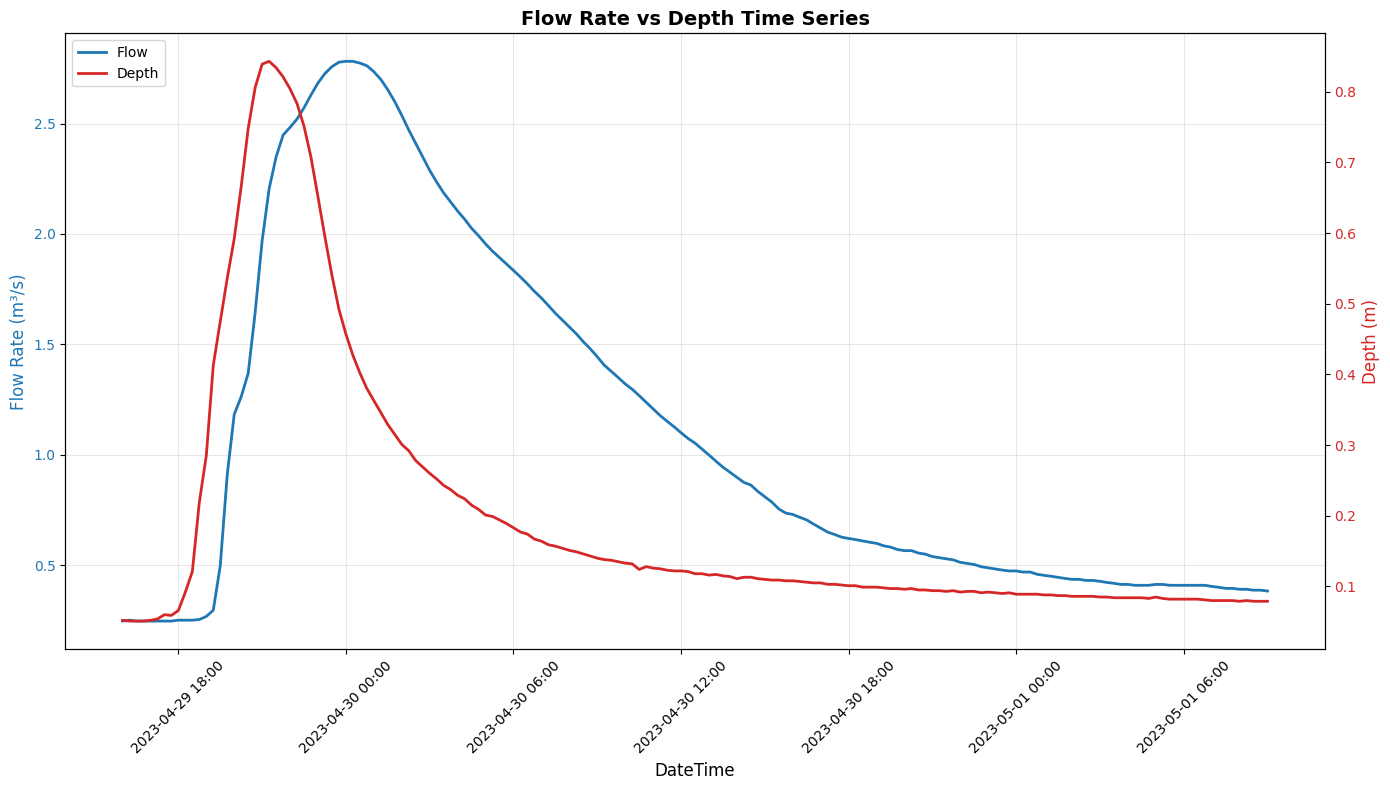

,dateTime,value_rain,value_flow,value_depth
count,165,165.000000,165.000000,165.000000
mean,2023-04-30 12:30:00,0.069091,1.095394,0.196667
min,2023-04-29 16:00:00,0.000000,0.247000,0.051000
25%,2023-04-30 02:15:00,0.000000,0.436000,0.088000
50%,2023-04-30 12:30:00,0.000000,0.717000,0.110000
75%,2023-04-30 22:45:00,0.000000,1.676000,0.201000
max,2023-05-01 09:00:00,2.800000,2.782000,0.843000
std,NaN,0.328080,0.804076,0.195438


In [ ]:
# clipping 
start_date = pd.to_datetime( '2023-04-29 16:00:00' )
end_date =   pd.to_datetime( '2023-05-01 09:00:00' )


df_filtered = df_combined[
    (df_combined['dateTime'] >= start_date) & 
    (df_combined['dateTime'] <= end_date)
].copy()

plot_hydrograph (df_filtered)
plot_flow_depth(df_filtered)
df_filtered.describe()

Basin characterisation and network construction functions
---

In [ ]:
# Actual Basin Characterisation and Utility Functions. Easier to implement here than in postgres. 

def calculate_basin_parameters(gdf, runoff_coefficient_modifier, retardence_coefficient_modifier):
    #Calculate working coefficients and drainage multiplier for each basin.
    
    # Returns:  updated GeoDataFrame with new calculated columns
    
    # 1. Calculate working_runoff_coefficient
    gdf['working_runoff_coefficient'] = (
        (gdf['runoff_coefficient_max'] - gdf['runoff_coefficient_min']) * runoff_coefficient_modifier ) + gdf['runoff_coefficient_min']
    
    # 2. Calculate drainage_multiplier
    gdf['drainage_multiplier'] = gdf['area'] * gdf['working_runoff_coefficient']
    
    # 3. Calculate working_retardence_coefficient
    gdf['working_retardence_coefficient'] = (
        (gdf['retardence_coefficient_max'] - gdf['retardence_coefficient_min']) * retardence_coefficient_modifier ) + gdf['retardence_coefficient_min']
    
    return gdf

def calculate_travel_time(gdf, stream_coefficient_modifier):
     #Calculate travel time for each basin based on stream condition.
    
    # Calculate slope (height_change / flow_distance) division by zero fix.
    slope = gdf['height_change'] / gdf['flow_distance'].replace(0, float('nan'))
    
    # pick travel time equation based on is_stream 
    gdf['travel_time'] = np.where(
        gdf['is_stream'] == 1,
        # Stream equation
        stream_coefficient_modifier * 0.0195 * (gdf['flow_distance']**0.77) * (slope**-0.385),
        # Non-stream equation
        1.44 * ((gdf['flow_distance'] * gdf['working_retardence_coefficient'])**0.467) * (slope**-0.235)
    )
    return gdf

def scale_rainfall_by_basin(gdf, rainfall_mm): 
    # Scale rainfall array for each basin by its drainage_multiplier.

    # Convert rainfall to numpy array 
    rainfall_array = np.array(rainfall_mm)
    
    # Create dictionary to store scaled rainfall for each basin
    scaled_rainfall = {}
    
    for _, row in gdf.iterrows():
        basin_id = row['basin_id']
        drainage_multiplier = row['drainage_multiplier']
        
        # Scale the rainfall array by drainage_multiplier
        scaled_rainfall[basin_id] = (rainfall_array * drainage_multiplier) / 1000 # div by a thousand becuase we want metres^3 not litres.
    
    return scaled_rainfall

# helper function that produces an output array long enough to contain delayed arrivals. control out_length for a fixed total length.
def shift_series_by_minutes_fractional(series, minutes, timestep_minutes=15, out_length=None):
#    Shift series by minutes, splitting each 15 minute timestep.
    
#    Returns a numpy array of length out_length with the shifted values.

    series = np.asarray(series, dtype=float)
    n_in = len(series)
    lag = minutes / float(timestep_minutes)
    lag_floor = int(math.floor(max(0.0, lag)))  # ensure non-negative
    lag_frac = lag - lag_floor
    
    # determine output length, errors plotting and comparing if there's a mismatch
    if out_length is None:
        out_length = n_in + lag_floor + 2  # +2 to be safe, 
    
    out = np.zeros(out_length, dtype=float)
    
    # portion spliting to the next time step down
    if lag_floor < out_length:
        end_idx = min(out_length - lag_floor, n_in)
        out[lag_floor:lag_floor + end_idx] += (1.0 - lag_frac) * series[:end_idx]
    
    # portion spilling into the next time step up
    if lag_floor + 1 < out_length:
        end_idx2 = min(out_length - (lag_floor + 1), n_in)
        out[lag_floor + 1:lag_floor + 1 + end_idx2] += lag_frac * series[:end_idx2]
    
    return out


def build_graph(links_df, dfo):

#    inputs: 
#    links_df: a dataframe containing the flow graph nodes and edges,
#    dfo: a dataframe containing the characterised basin values

#    returns:
#    a networkX graph of the basin with populated flow values. 

    G = nx.DiGraph()
    travel_times = dict(zip(dfo['basin_id'], dfo['travel_time']))
    
    for _, row in links_df.iterrows():
        u = int(row['upstream_basin_id_int'])
        v = int(row['downstream_basin_id_int'])
        if pd.notnull(v):
            # assign upstream node's travel_time as edge weight
            G.add_edge(u, v, weight=travel_times.get(u, 0.0))
    
    return G

def populate_graph_with_travel_times(G, dfo, target_basin):

#    inputs:
#    G: a NetworkX graph
#    dfo: basin characterisation values.
#    target_basin: the ID number of the target basin. 

#    returns: all of the above, and a graph populated with travel times. 

    # Make sure all nodes have a travel_time attribute
    e = 0
    for node in G.nodes:
        if "travel_time" not in G.nodes[node]:
            e+=1
            G.nodes[node]["travel_time"] = 0.0  # default for missing nodes. Just skip them, in the absence of a better option. 
    
    G_rev = G.reverse(copy=True)

    # cumulative travel time from each basin to target. No routing, Dijkstra is here as a convenience function to sum the weights. 
    cumulative_tt = nx.single_source_dijkstra_path_length(G_rev, target_basin, weight="weight")
    dfo["cumulative_travel_time"] = dfo["basin_id"].map(cumulative_tt)
    
    return dfo, G, G_rev, cumulative_tt

# Build a hydrograph. 

def build_hydrograph(G, dfo, interp_rainfall, cumulative_tt, timestep_minutes=15): #new zero-safe implementation
#    Build a hydrograph avoiding NaNs.
    
#    inputs:
#    G : networkx DiGraph, the basin graph.
##    dfo : GeoDataFrame with basin attributes including travel times.
#    interp_rainfall : dict Basin-wise rainfall array.
#    cumulative_tt : dict Basin cumulative travel times to the target (minutes).
#    timestep_minutes : int Timestep of rainfall/flow in minutes.
        
#    Returns:
#    modelled_q : np.ndarray Hydrograph in m^3, aligned with rf_df length.
 
    basins_with_rain = set(interp_rainfall.keys())
    basins_with_tt = set(cumulative_tt.keys())
    basins = sorted(list(basins_with_rain & basins_with_tt))
    
    # Max travel time to size output array
    max_minutes = max(cumulative_tt[b] for b in basins)
    max_lag_steps = int(np.ceil(max_minutes / timestep_minutes))
    
    # Max input length
    input_len = max(len(interp_rainfall[b]) for b in basins)
    out_length = input_len + max_lag_steps + 2
    
    total_volume = np.zeros(out_length, dtype=float)
    
    missing_tt = []
    for b in basins:
        series = np.array(interp_rainfall[b], dtype=float)
        minutes = cumulative_tt.get(b, 0.0)
        
        shifted = shift_series_by_minutes_fractional(series, minutes, timestep_minutes=timestep_minutes, out_length=out_length)
        shifted = np.nan_to_num(shifted, nan=0.0)  # replace NaN with 0
        
        # add to total volume
        total_volume[:len(shifted)] += shifted
    
    # convert to discharge (m^3/s)
    timestep_seconds = timestep_minutes * 60
    total_discharge = total_volume / timestep_seconds
    
    # align to observation length
    L_obs = len(rf_df)
    modelled_q = total_discharge[:L_obs]
    
    return modelled_q

def plot_hydrograph(modelled_q, actual_q):
    # convenience function to plot two hydrographs side-by-side. 
    time_index = np.arange(len(rf_df)) * 15  # minutes since start
    plt.plot(time_index, modelled_q, label='Modelled')
    plt.plot(time_index, actual_q.values[:len(rf_df)], label='Observed', alpha=0.7)
    plt.xlabel('Time since start (minutes)')
    plt.ylabel('Discharge (m³/s)')

def populate_dataframe(gdf, runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, rainfall_object):
    # wrapper for basin parameterisation application.
    gdf = calculate_basin_parameters(gdf, runoff_coefficient_modifier, retardence_coefficient_modifier)
    gdf = calculate_travel_time(gdf, stream_coefficient_modifier)
    rainfall_obj = scale_rainfall_by_basin(gdf, rainfall_object)
    return gdf, rainfall_obj


def run_model(runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, gdf, links_df, rf_df):
    # actually run a model given a set of runoff coefficient modifiers. 
    gdf_local = gdf.copy()
    links_df_local = links_df.copy()
    rf_df_local = rf_df.copy()
    
    rainfall_object = rf_df.value_rain
    
    gdf_local = calculate_basin_parameters(gdf_local, runoff_coefficient_modifier, retardence_coefficient_modifier)
    gdf_local = calculate_travel_time(gdf_local, stream_coefficient_modifier)
    gdf_local, interp_rainfall = populate_dataframe(gdf_local, runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, rainfall_object)
    
    interp_rainfall = scale_rainfall_by_basin(gdf_local, rainfall_object)
    
    #dumpname =  datetime.datetime.now().__str__() # save the object to file for error checking and presentation purposes. 
    #dfo.to_file(dumpname)
    
    G = build_graph(links_df_local, gdf_local)
    gdf_local, G, G_rev, cumulative_tt = populate_graph_with_travel_times(G, gdf_local, target_basin)
    
    return build_hydrograph(G, gdf_local, interp_rainfall, cumulative_tt)

#Validation/effectiveness/objective functions

# 1. Root Mean Square Error (RMSE)
def rmse(Q_sim, Q_obs):
    return np.sqrt(np.mean((Q_sim - Q_obs) ** 2))

# 2. Nash–Sutcliffe Efficiency (NSE)
def nse(Q_sim, Q_obs):
    return 1 - np.sum((Q_sim - Q_obs) ** 2) / np.sum((Q_obs - np.mean(Q_obs)) ** 2)

# 3. Kling–Gupta Efficiency (KGE)
def kge(Q_sim, Q_obs):
    r = np.corrcoef(Q_sim, Q_obs)[0, 1]
    alpha = np.std(Q_sim) / np.std(Q_obs)
    beta = np.mean(Q_sim) / np.mean(Q_obs)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# plot comparing two hydrographs (e.g., actual vs modelled).
def compare_hydrograph(modelled_q, actual_q, time_index=None):
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Use provided time_index or create default
    if time_index is None:
        time_index = np.arange(len(modelled_q)) * 15  # minutes since start
    
    # Plot modelled and observed discharge on primary axis
    line1 = ax1.plot(time_index, modelled_q, color='tab:blue', linewidth=2, label='Modelled')
    line2 = ax1.plot(time_index, actual_q.values[:len(modelled_q)], color='tab:red', linewidth=2, alpha=0.7, label='Observed')
    
    # Configure primary axis
    ax1.set_xlabel('Time since start (minutes)', fontsize=12)
    ax1.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis if it's datetime-based
    if len(time_index) > 0 and isinstance(time_index[0], (np.datetime64, pd.Timestamp)):
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Add legend
    ax1.legend(loc='upper right')
    
    # Add title
    plt.title('Modelled vs Observed Hydrograph (Validation)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    
    plt.show()

# comparison stats for the two hydrographs. 
def hydrograph_stats(obs, sim):
    # align lengths
    n = min(len(obs), len(sim))
    obs, sim = np.array(obs[:n]), np.array(sim[:n])
    
    # basic flow descriptors
    stats = {
        "Mean flow (m³/s)": (np.mean(sim), np.mean(obs)),
        "Peak flow (m³/s)": (np.max(sim), np.max(obs)),
        "Time to peak (index)": (np.argmax(sim), np.argmax(obs)),
        "Flow variance": (np.var(sim), np.var(obs)),
        "Skewness": (skew(sim), skew(obs)),
        "Kurtosis": (kurtosis(sim), kurtosis(obs)),
        "Volume (sum of flow)": (np.sum(sim), np.sum(obs))
    }
    
    print("\nHydrograph Shape Comparison:\n(simulated vs. observed)\n")
    for k, (s, o) in stats.items():
        print(f"{k:25s}: Sim = {s:8.3f} | Observed = {o:8.3f} | Ratio = {s/o:6.2f}")
    
    # derived timing/shape indicators
    t_diff = np.argmax(sim) - np.argmax(obs)
    print(f"\nΔ Time to peak (sim - obs): {t_diff:+d} timesteps")
    print(f"Relative peak ratio: {np.max(sim)/np.max(obs):.2f}")
    print(f"Relative volume ratio: {np.sum(sim)/np.sum(obs):.2f}")

# objective functions
def objective_rmse(params_matrix):
    """Objective function for PSO – returns RMSE per particle."""
    costs = []
    for params in params_matrix:
        runoff, retardence, stream = params
        q_model = run_model(runoff, retardence, stream, gdf, links_df, rf_df)
        q_obs = rf_df.value_flow.values[:len(q_model)]
        costs.append(rmse(q_model, q_obs))
    return np.array(costs)

def get_isbasin_information(target_basin, engine):
    query = f"""
    with basins as (
    WITH RECURSIVE upstream_basins AS (
        -- Start with the target basin
        SELECT
            l.upstream_basin_id_int,
            l.downstream_basin_id_int,
            0 AS depth
        FROM process_environment_drainage.isobasin_links l  -- previously working.isobasin_links_clean during development.
        WHERE l.downstream_basin_id_int = {target_basin}

        UNION ALL

        -- Recurse: find basins that flow into the previous step's upstreams
        SELECT
            l.upstream_basin_id_int,
            l.downstream_basin_id_int,
            ub.depth + 1 AS depth
        FROM process_environment_drainage.isobasin_links l  -- previously working.isobasin_links_clean during development.
        INNER JOIN upstream_basins ub
            ON l.downstream_basin_id_int = ub.upstream_basin_id_int
    )
    -- Return the list of isobasins
    SELECT DISTINCT upstream_basin_id_int AS basin_id, depth
    FROM upstream_basins
    ORDER BY depth, basin_id
    )
    -- 4.Get the Basin data.  
    select distinct
    basin_id,
    height_change,
    flow_distance,
    is_stream,
    retardence_coefficient_min,
    retardence_coefficient_max,
    area,
    runoff_coefficient_min,
    runoff_coefficient_max,
    geom
    from process_environment_drainage.isobasin_properties where basin_id -- previously working.isobasin_properties_clean during development
    in (select distinct basin_id from basins)
    """
    return gpd.read_postgis(query, engine, geom_col='geom').set_crs(epsg=27700)

def get_network_graph(target_basin, engine):
    query = f"""
    WITH RECURSIVE upstream_basins AS (
        SELECT
            l.upstream_basin_id_int,
            l.downstream_basin_id_int
        FROM working.isobasin_links_clean l
        WHERE l.downstream_basin_id_int = {target_basin}

        UNION ALL

        SELECT
            l.upstream_basin_id_int,
            l.downstream_basin_id_int
        FROM process_environment_drainage.isobasin_links l  -- previously working.isobasin_links_clean during development.
        INNER JOIN upstream_basins ub
            ON l.downstream_basin_id_int = ub.upstream_basin_id_int
    )
    SELECT DISTINCT upstream_basin_id_int, downstream_basin_id_int
    FROM upstream_basins
    """
    return pd.read_sql(query, engine)



Configure the Optimiser and Load the Graph Characterisation Data 
--

In [ ]:
# configure optimiser. 


# PSO parameter bounds
bounds = [(0.0, 1.0),  # runoff coefficient modifier
          (0.0, 1.0),  # retardance coefficient modifier
          (0.0, 1.0)]  # stream coefficient modifier

# Clerc & Kennedy (2002) recommended PSO parameters
options = {
    'c1': 1.49445,   # cognitive coefficient
    'c2': 1.49445,   # social coefficient
    'w': 0.729       # inertia weight (constriction factor)
}

# Initialise PSO optimiser
optimizer = GlobalBestPSO(
    n_particles=50,
    dimensions=3,
    options=options,
    bounds=(np.array([b[0] for b in bounds]),
            np.array([b[1] for b in bounds]))
)

calibration_basin  = 37333
validation_basin = 35862

# pick a target basin
target_basin = calibration_basin

rf_df = df_filtered.copy()
gdf = get_isbasin_information(target_basin, engine)
links_df = get_network_graph(target_basin, engine)

In [ ]:
# run the optimiser. 

# placeholder with correct values: 
# for May 2023, values are: Best parameters: [0.25153698 0.10189646 0.49038137] with cost (RMSE): 0.24966895209926
# revised: Best parameters: [0.18104518 0.01631759 0.4590375 ] with cost (RMSE): 0.24061943790854215
best_cost = 0.24
best_pos = [0.18104518, 0.01631759, 0.4590375 ]

# commented out to avoid accidental runs. 
# best_cost, best_pos = optimizer.optimize(objective_rmse, iters=100)

print("Best parameters:", best_pos, "with cost (RMSE):", best_cost)


Best parameters: [0.18104518, 0.01631759, 0.4590375] with cost (RMSE): 0.24


Calibration hydrograph and fit metrics
--

RMSE = 0.321 m³/s
NSE  = 0.840
KGE  = 0.785


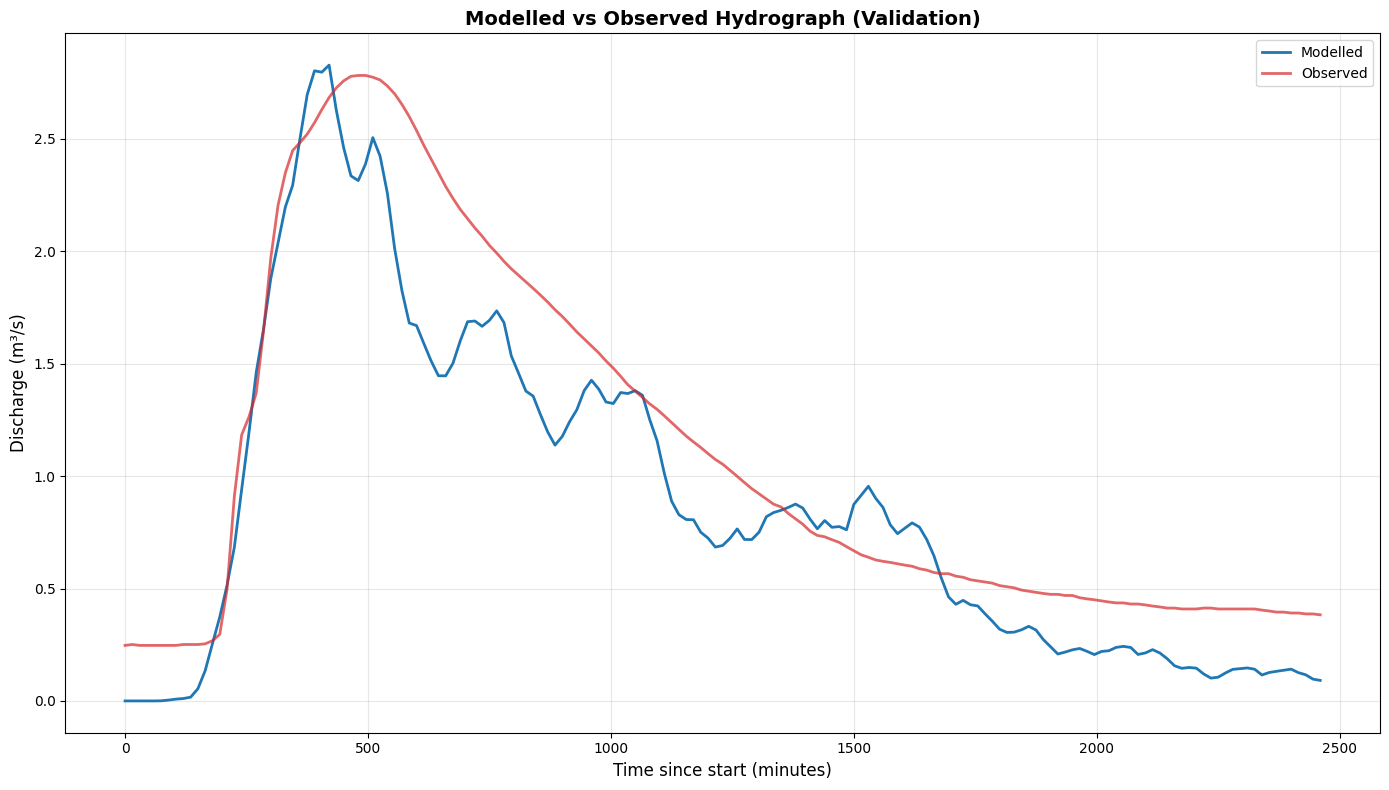

In [ ]:
#Best parameters: [0.15286737 0.98297695 0.21513863] with cost (RMSE): 0.13196175312726866
runoff_coefficient_modifier=best_pos[0] 
retardence_coefficient_modifier=best_pos[1]
stream_coefficient_modifier=best_pos[2]

c = run_model(runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, gdf, links_df, df_filtered)

print(f"RMSE = {rmse(c, df_filtered.value_flow):.3f} m³/s")
print(f"NSE  = {nse(c, df_filtered.value_flow):.3f}")
print(f"KGE  = {kge(c, df_filtered.value_flow):.3f}")

compare_hydrograph(c, rf_df.value_flow)

In [ ]:
# establish performance for that model iteration.
%timeit run_model(runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, gdf, links_df, df_filtered)

300 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# compare observed vs. measured hydrograph
hydrograph_stats(c, rf_df.value_flow)



Hydrograph Shape Comparison:
(simulated vs. observed)

Mean flow (m³/s)         : Sim =    1.095 | Observed =    0.881 | Ratio =   1.24
Peak flow (m³/s)         : Sim =    2.782 | Observed =    2.828 | Ratio =   0.98
Time to peak (index)     : Sim =   32.000 | Observed =   28.000 | Ratio =   1.14
Flow variance            : Sim =    0.643 | Observed =    0.549 | Ratio =   1.17
Skewness                 : Sim =    0.826 | Observed =    0.825 | Ratio =   1.00
Kurtosis                 : Sim =   -0.713 | Observed =   -0.168 | Ratio =   4.26
Volume (sum of flow)     : Sim =  180.740 | Observed =  145.352 | Ratio =   1.24

Δ Time to peak (sim - obs): +4 timesteps
Relative peak ratio: 0.98
Relative volume ratio: 1.24


Run the model for the validation basin
===

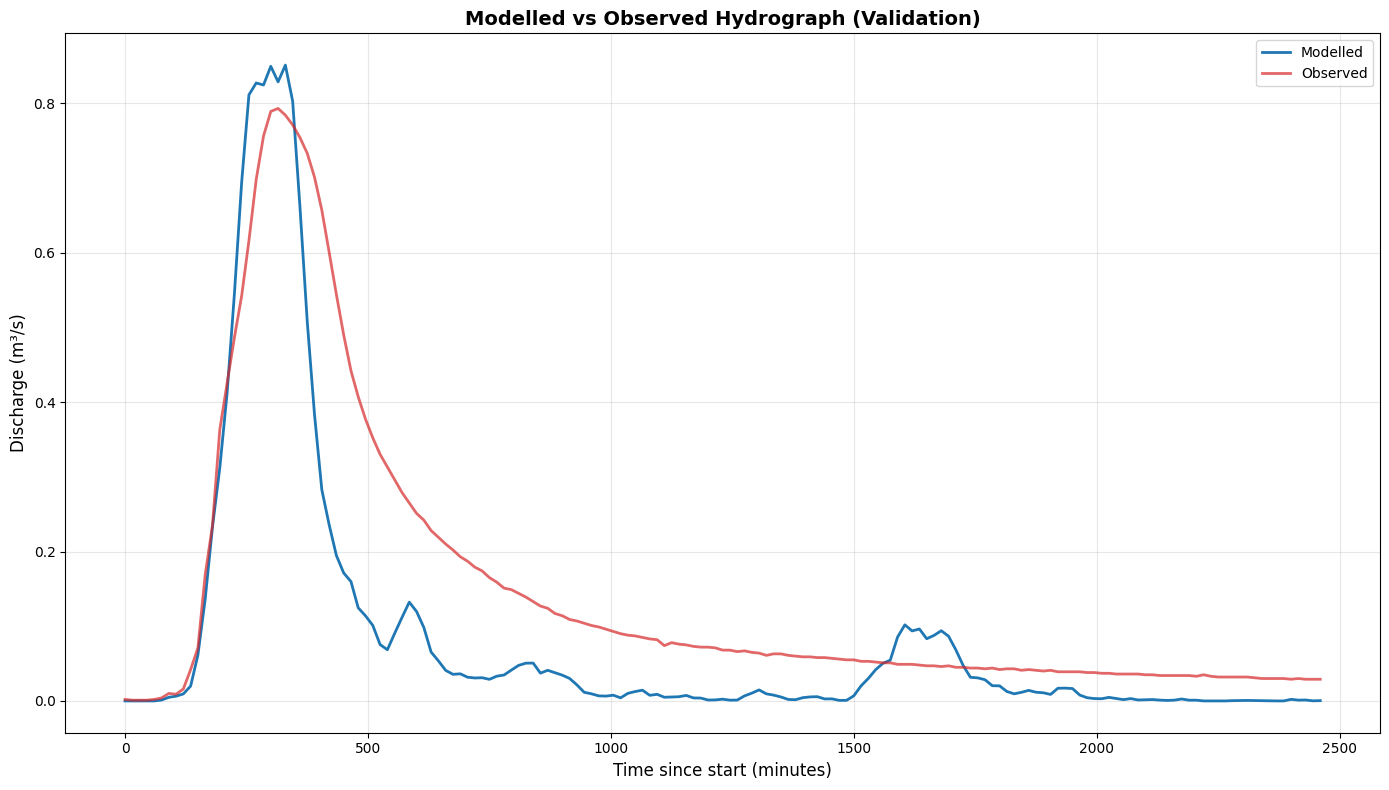

In [ ]:
calibration_basin  = 37333
validation_basin = 35862

# pick a target basin
target_basin = validation_basin

rf_df = df_filtered.copy()
gdf = get_isbasin_information(target_basin, engine)
links_df = get_network_graph(target_basin, engine)

v = run_model(runoff_coefficient_modifier, retardence_coefficient_modifier, stream_coefficient_modifier, gdf, links_df, df_filtered)
compare_hydrograph(v, rf_df.value_depth)

# this is a depth vs flow plot it may not necessarily be a good fit.

In [ ]:
df_filtered = pd.read_csv(f"results/{identifier}.csv") # Add in the manning derived flows.
df_filtered.head()

,Unnamed: 0,dateTime,value_rain,value_flow,value_depth,modelled_flow_at_depth_gauge,manning_derived_flow_at_depth_gauge
0,1504,2023-04-29 16:00:00,0.0,0.000,0.002,0.0,0.005974
1,1505,2023-04-29 16:15:00,0.0,0.004,0.001,0.0,0.005838
2,1506,2023-04-29 16:30:00,0.0,0.000,0.001,0.0,0.005838
3,1507,2023-04-29 16:45:00,0.0,0.000,0.001,0.0,0.005838
4,1508,2023-04-29 17:00:00,0.0,0.000,0.002,0.0,0.005974


Compare Discharges at the Validation site.
===

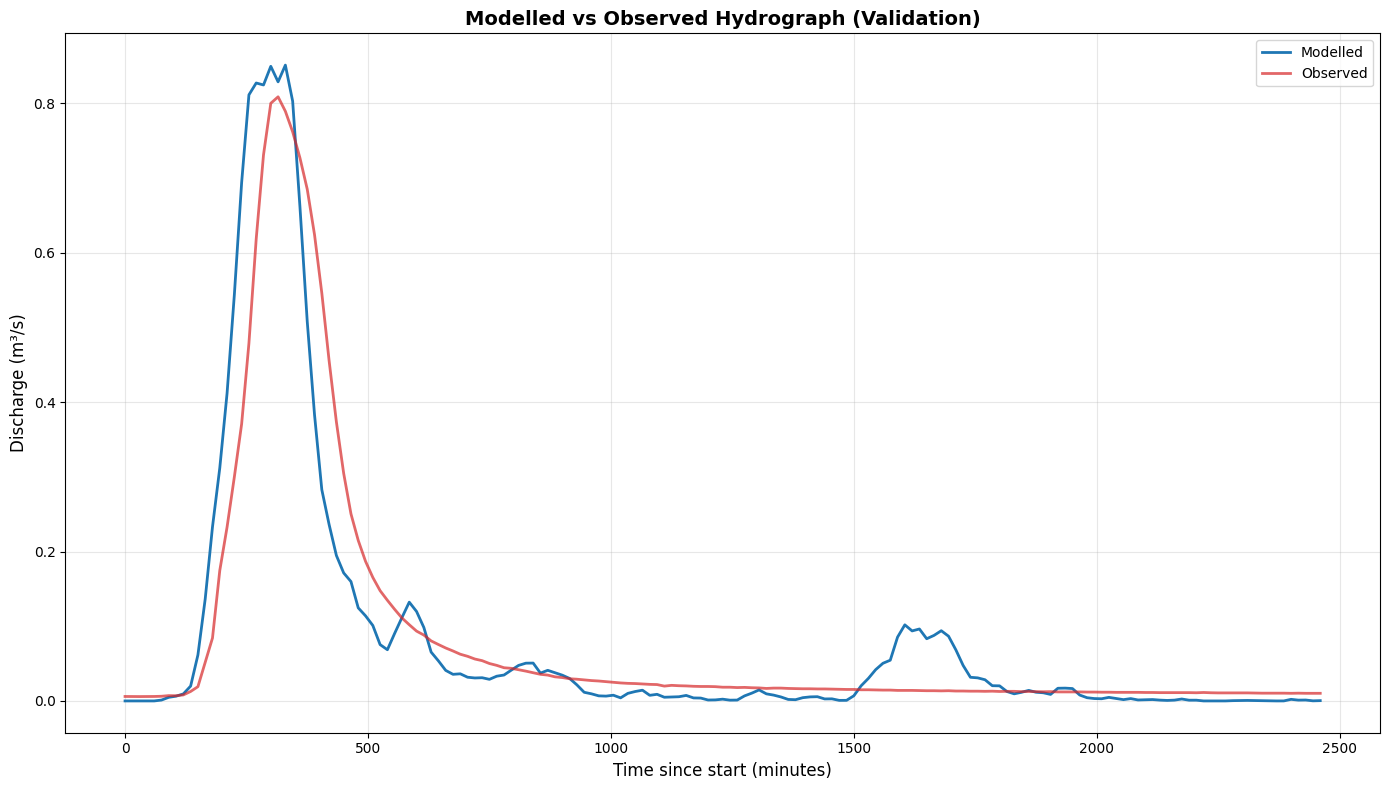

In [ ]:
compare_hydrograph(df_filtered['modelled_flow_at_depth_gauge'], df_filtered['manning_derived_flow_at_depth_gauge'])

In [ ]:
print(f"RMSE = {rmse(df_filtered['modelled_flow_at_depth_gauge'], df_filtered['manning_derived_flow_at_depth_gauge']):.3f} m³/s")
print(f"NSE  = {nse(df_filtered['modelled_flow_at_depth_gauge'], df_filtered['manning_derived_flow_at_depth_gauge']):.3f}")
print(f"KGE  = {kge(df_filtered['modelled_flow_at_depth_gauge'], df_filtered['manning_derived_flow_at_depth_gauge']):.3f}")

RMSE = 0.069 m³/s
NSE  = 0.848
KGE  = 0.901


In [ ]:
hydrograph_stats(df_filtered['modelled_flow_at_depth_gauge'], df_filtered['manning_derived_flow_at_depth_gauge'])


Hydrograph Shape Comparison:
(simulated vs. observed)

Mean flow (m³/s)         : Sim =    0.086 | Observed =    0.086 | Ratio =   0.99
Peak flow (m³/s)         : Sim =    0.809 | Observed =    0.851 | Ratio =   0.95
Time to peak (index)     : Sim =   21.000 | Observed =   22.000 | Ratio =   0.95
Flow variance            : Sim =    0.032 | Observed =    0.036 | Ratio =   0.87
Skewness                 : Sim =    2.906 | Observed =    3.043 | Ratio =   0.95
Kurtosis                 : Sim =    7.490 | Observed =    8.349 | Ratio =   0.90
Volume (sum of flow)     : Sim =   14.167 | Observed =   14.254 | Ratio =   0.99

Δ Time to peak (sim - obs): -1 timesteps
Relative peak ratio: 0.95
Relative volume ratio: 0.99


Sensitivity Analysis
---
permutation analysis to assess the impact of each parameter on overall model performance. 

In [ ]:

# percentage deviations to test
scales = [0.5, 0.75, 0.9, 1.0, 1.1, 1.25, 1.5]

# empty results list
results = []

#  Loop thorugh each parameter
for param in baseline.keys():
    for scale in scales:
        # copy baseline values and modify just one parameter
        modifiers = baseline.copy()
        modifiers[param] = scale * baseline[param]

        sim = run_model( # run model with adjusted coefficients.
            modifiers["runoff_coefficient_modifier"],
            modifiers["retardence_coefficient_modifier"],
            modifiers["stream_coefficient_modifier"],
            gdf,
            links_df,
            df_filtered,
        )

         # ---- observed vs simulated ----
        obs = df_filtered["value_flow"].values
        mod = np.array(sim, dtype=float)

        # ---- calculate performance metrics ----
        NSE = 1 - np.sum((mod - obs) ** 2) / np.sum((obs - np.mean(obs)) ** 2)
        bias = (mod.sum() - obs.sum()) / obs.sum() * 100
        peak_err = (mod.max() - obs.max()) / obs.max() * 100
        # time difference between peaks
        time_step_min = ( df_filtered["dateTime"].iloc[1] - df_filtered["dateTime"].iloc[0] ).total_seconds() / 60
        peak_lag = (np.argmax(mod) - np.argmax(obs)) * time_step_min

         # store the results
        results.append(
            [param, scale, NSE, bias, peak_err, peak_lag]
        )

sensitivity_df = pd.DataFrame(
    results,
    columns=["Parameter", "Scale", "NSE", "Volume Bias %", "Peak Error %", "PeakLag (min)"],
)

# sort 
sensitivity_df.sort_values(by=["Parameter", "Scale"], inplace=True)
display(sensitivity_df)

,Parameter,Scale,NSE,Volume Bias %,Peak Error %,PeakLag (min)
7,retardence_coefficient_modifier,0.50,0.838830,-19.136806,4.207528,-105.0
8,retardence_coefficient_modifier,0.75,0.849200,-19.398037,2.694706,-90.0
9,retardence_coefficient_modifier,0.90,0.845210,-19.502470,1.994113,-90.0
10,retardence_coefficient_modifier,1.00,0.839973,-19.579232,1.648509,-60.0
11,retardence_coefficient_modifier,1.10,0.833975,-19.644768,1.481612,-60.0
12,retardence_coefficient_modifier,1.25,0.824525,-19.750718,1.087189,-60.0
13,retardence_coefficient_modifier,1.50,0.811574,-19.910819,0.543551,-60.0
0,runoff_coefficient_modifier,0.50,0.001929,-59.789616,-49.175745,-60.0
1,runoff_coefficient_modifier,0.75,0.549834,-39.684424,-23.763618,-60.0
2,runoff_coefficient_modifier,0.90,0.754849,-27.621309,-8.516341,-60.0


Senstitivity Analysis plots, NSE vs. Parameter scale
---

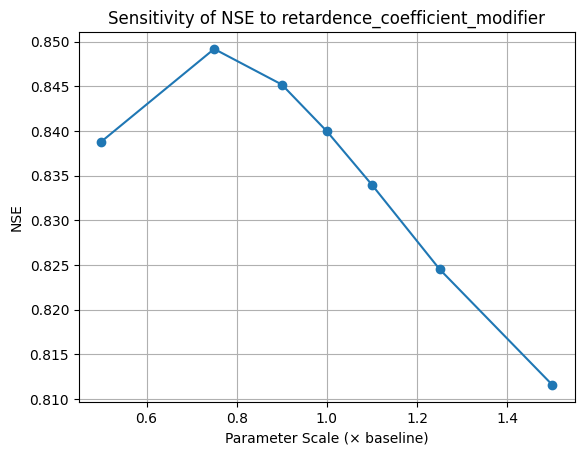

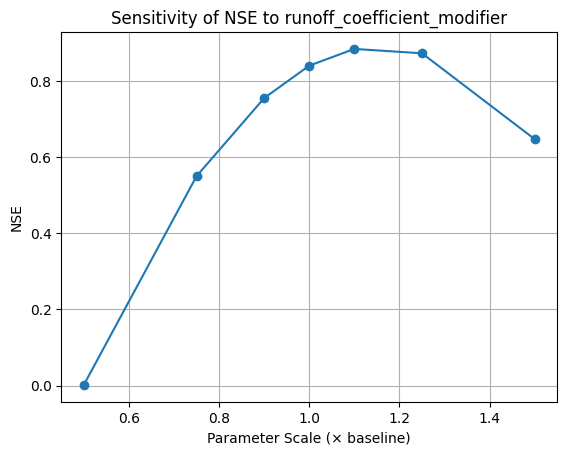

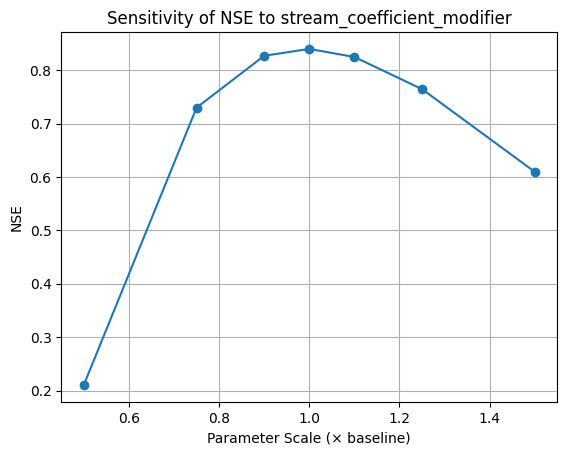

In [ ]:
import matplotlib.pyplot as plt

for param in sensitivity_df["Parameter"].unique():
    subset = sensitivity_df[sensitivity_df["Parameter"] == param]
    plt.figure()
    plt.plot(subset["Scale"], subset["NSE"], marker="o")
    plt.title(f"Sensitivity of NSE to {param}")
    plt.xlabel("Parameter Scale (× baseline)")
    plt.ylabel("NSE")
    plt.grid(True)
    plt.show()